In [6]:
import robust_regression.sweeps.eps_sweep as epsw
import matplotlib.pyplot as plt
from robust_regression.fixed_point_equations.fpe_L2_loss import (
    var_hat_func_L2_decorrelated_noise,
)
from tqdm.auto import tqdm
import robust_regression.regression_numerics.data_generation as dg
import robust_regression.aux_functions.prior_regularization_funcs as priors
import robust_regression.aux_functions.likelihood_channel_functions as like
import robust_regression.regression_numerics.amp_funcs as amp
import robust_regression.regression_numerics.erm_solvers as erm
from robust_regression.utils.errors import ConvergenceError
from robust_regression.fixed_point_equations.fpe_BO import var_func_BO, var_hat_func_BO_num_decorrelated_noise
from robust_regression.fixed_point_equations.fpe_L1_loss import (
    var_hat_func_L1_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_Huber_loss import (
    var_hat_func_Huber_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_L2_regularization import var_func_L2
from robust_regression.aux_functions.misc import estimation_error, excess_gen_error, gen_error_BO
import numpy as np

In [2]:
def sigma_order_param(m, q, sigma):
    return sigma


def q_order_param(m, q, sigma):
    return q


def m_order_param(m, q, sigma):
    return m

## Theory Simulation

In [4]:
alpha, delta_in, delta_out, beta = 10.0, 1.0, 5.0, 0.0
eps_min, eps_max, n_eps_pts = 0.0001, 1.0, 1000
n_eps_pts_BO = 15

In [5]:
while True:
    m = 0.89 * np.random.random() + 0.1
    q = 0.89 * np.random.random() + 0.1
    sigma = 0.89 * np.random.random() + 0.1
    if np.square(m) < q + delta_in * q and np.square(m) < q + delta_out * q:
        initial_condition = [m, q, sigma]
        break

epsilons_l2, e_gen_l2, reg_params_opt_l2, (ms_l2, qs_l2, sigmas_l2) = epsw.sweep_eps_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L2_decorrelated_noise,
    eps_min,
    eps_max,
    n_eps_pts,
    delta_in,
    {"reg_param": 3.0},
    {
        "alpha": alpha,
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": 0.3,
        "beta": beta,
    },
    initial_cond_fpe=initial_condition,
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": 0.3, "beta": beta},
    update_f_min_args=True,
    funs=[m_order_param, q_order_param, sigma_order_param],
    funs_args=[{}, {}, {}],
    linear=True
)

print("L2 done")

epsilons_l1, e_gen_l1, reg_params_opt_l1, (ms_l1, qs_l1, sigmas_l1) = epsw.sweep_eps_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L1_decorrelated_noise,
    eps_min,
    eps_max,
    n_eps_pts,
    0.5,
    {"reg_param": 3.0},
    {
        "alpha": alpha,
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": 0.3,
        "beta": beta,
    },
    initial_cond_fpe=initial_condition,
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": 0.3, "beta": beta},
    update_f_min_args=True,
    funs=[m_order_param, q_order_param, sigma_order_param],
    funs_args=[{}, {}, {}],
    linear=True
)

print("L1 done")

(
    epsilons_hub,
    e_gen_hub,
    (reg_params_opt_hub, hub_params_opt),
    (ms_hub, qs_hub, sigmas_hub),
) = epsw.sweep_eps_optimal_lambda_hub_param_fixed_point(
    var_func_L2,
    var_hat_func_Huber_decorrelated_noise,
    eps_min,
    eps_max,
    n_eps_pts,
    [0.5, 1.0],
    {"reg_param": 3.0},
    {
        "alpha": alpha,
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": 0.3,
        "beta": beta,
        "a": 1.0,
    },
    initial_cond_fpe=initial_condition,
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": 0.3, "beta": beta},
    update_f_min_args=True,
    funs=[m_order_param, q_order_param, sigma_order_param],
    funs_args=[{}, {}, {}],
    linear=True
)

print("Huber done")

(
    epsilons_BO,
    (gen_error_BO_old, qs_BO),
) = epsw.sweep_eps_fixed_point(
    var_func_BO,
    var_hat_func_BO_num_decorrelated_noise,
    eps_min,
    eps_max,
    n_eps_pts_BO,
    {"reg_param": 3.0},
    {
        "alpha": alpha,
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": 0.3,
        "beta": beta,
    },
    initial_cond=(0.6, 0.01, 0.9),
    funs=[gen_error_BO, q_order_param],
    funs_args=[{"delta_in": delta_in, "delta_out": delta_out, "percentage": 0.3, "beta": beta}, {}],
    update_funs_args=[True, False],
    decreasing=False,
    linear=True
)

print("BO done")

L2 done
L1 done
Huber done
BO done


## Numerical Experiments

In [20]:
d = 300
repetitions = 50

idxs_chosen = np.linspace(0, len(epsilons_l2)-1, 20, dtype=int)

print("epsilons expample\n", epsilons_l2[idxs_chosen])

epsilons expample
 [1.00000000e-04 5.21468468e-02 1.05194595e-01 1.57241441e-01
 2.10289189e-01 2.62336036e-01 3.15383784e-01 3.68431532e-01
 4.20478378e-01 4.73526126e-01 5.25572973e-01 5.78620721e-01
 6.30667568e-01 6.83715315e-01 7.36763063e-01 7.88809910e-01
 8.41857658e-01 8.93904505e-01 9.46952252e-01 1.00000000e+00]


In [9]:
epsilons_list_sim_L2 = epsilons_l2[idxs_chosen]
lambd_list_L2 = reg_params_opt_l2[idxs_chosen]

L2_gen_error_sim_mean = np.zeros(len(epsilons_list_sim_L2))
L2_gen_error_sim_std = np.zeros(len(epsilons_list_sim_L2))

for i, (eps, lambd) in enumerate(zip(tqdm(epsilons_list_sim_L2), lambd_list_L2)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, eps, beta),
        )

        estimated_theta = erm.find_coefficients_L2(ys, xs, lambd)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - eps + eps * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L2_gen_error_sim_mean[i], L2_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("L2 sim done")

  0%|          | 0/30 [00:00<?, ?it/s]

L2 sim done


In [15]:
epsilons_list_sim_Hub = epsilons_hub[idxs_chosen]
a_list_Hub = hub_params_opt[idxs_chosen]
lambd_list_Hub = reg_params_opt_hub[idxs_chosen]

Huber_gen_error_sim_mean = np.zeros(len(epsilons_list_sim_Hub))
Huber_gen_error_sim_std = np.zeros(len(epsilons_list_sim_Hub))


for i, (eps, lambd, a) in enumerate(zip(tqdm(epsilons_list_sim_Hub), lambd_list_Hub, a_list_Hub)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, eps, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - eps + eps * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    Huber_gen_error_sim_mean[i], Huber_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("Huber sim done.")

  0%|          | 0/30 [00:00<?, ?it/s]

Huber sim done.


In [17]:
epsilons_list_sim_L1 = epsilons_l1[idxs_chosen]
lambd_list_L1 = reg_params_opt_l1[idxs_chosen]

a_val_L1 = 1e-3
lambd_list_L1 *= a_val_L1

L1_gen_error_sim_mean = np.zeros(len(epsilons_list_sim_L1))
L1_gen_error_sim_std = np.zeros(len(epsilons_list_sim_L1))

for i, (eps, lambd) in enumerate(zip(tqdm(epsilons_list_sim_L1), lambd_list_L1)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, eps, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a_val_L1)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - eps + eps * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L1_gen_error_sim_mean[i], L1_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("L1 sim done.")

  0%|          | 0/30 [00:00<?, ?it/s]

L1 sim done.


In [21]:
eps_list = np.linspace(eps_min, eps_max, n_eps_pts)

eps_list_sim = eps_list[idxs_chosen]

means_gen_error = []
stds_gen_error = [] 

eps_2 = []

for idx, percentage in enumerate(tqdm(eps_list_sim)):
    all_gen_errors = []
    all_estim_errors = []

    for _ in range(repetitions):
        try:
            xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
                dg.measure_gen_decorrelated,
                n_features=d,
                n_samples=max(int(np.around(d * alpha)), 1),
                n_generalization=2 * d,
                measure_fun_args=(delta_in, delta_out, percentage, beta),
            )

            estimated_theta, _ = amp.GAMP_unsimplified_iters(
                priors.f_w_Bayes_gaussian_prior,
                priors.Df_w_Bayes_gaussian_prior,
                like.f_out_Bayes_decorrelated_noise,
                like.Df_out_Bayes_decorrelated_noise,
                ys,
                xs,
                (0.0, 1.0),
                (delta_in, delta_out, percentage, beta),
                np.random.normal(size=d),
                1.0,
                max_iter=10_000,
                blend=0.85,
                abs_tol=1e-3
            )

            all_gen_errors.append(
                np.mean((ys_test - (1 - percentage + percentage * beta) * xs_test @ estimated_theta / np.sqrt(d)) ** 2)
                - np.mean(
                    (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
                )
            )

            all_estim_errors.append(np.mean(np.square(estimated_theta - ground_truth_theta)))

            del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

        except ConvergenceError:
            continue

    means_gen_error.append(np.mean(all_gen_errors))
    stds_gen_error.append(np.std(all_gen_errors) / np.sqrt(repetitions))

    eps_2.append(percentage)

print("GAMP done.")

  0%|          | 0/20 [00:00<?, ?it/s]

GAMP done.


## Plotting

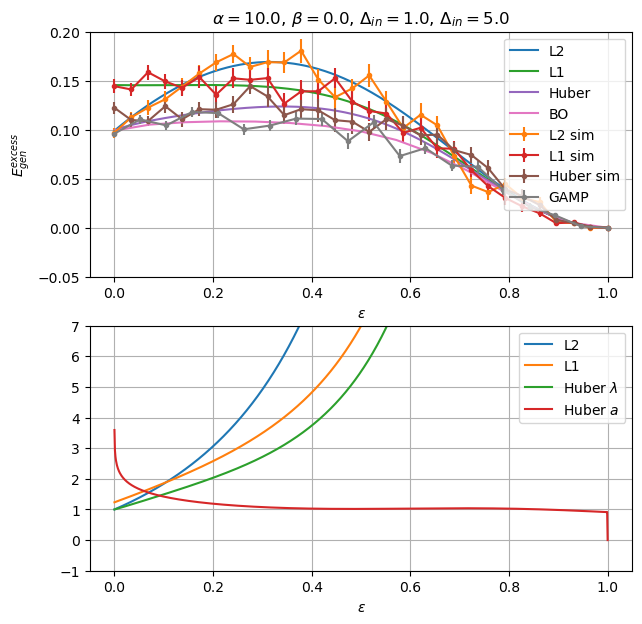

In [22]:
plt.figure(figsize=(7, 7))

plt.subplot(211)
plt.title(
    r"$\alpha = {}$, $\beta = {}$, $\Delta_{{in}} = {}$, $\Delta_{{in}} = {}$".format(alpha, beta, delta_in, delta_out)
)
plt.plot(epsilons_l2, e_gen_l2, label="L2")
plt.errorbar(
    epsilons_list_sim_L2, L2_gen_error_sim_mean, yerr=L2_gen_error_sim_std, label="L2 sim", linestyle=None, marker="."
)
plt.plot(epsilons_l1, e_gen_l1, label="L1")
plt.errorbar(
    epsilons_list_sim_L1, L1_gen_error_sim_mean, yerr=L1_gen_error_sim_std, label="L1 sim", linestyle=None, marker="."
)
plt.plot(epsilons_hub, e_gen_hub, label="Huber")
plt.errorbar(
    epsilons_list_sim_Hub,
    Huber_gen_error_sim_mean,
    yerr=Huber_gen_error_sim_std,
    label="Huber sim",
    linestyle=None,
    marker=".",
)
plt.plot(epsilons_BO, gen_error_BO_old, label="BO")
plt.errorbar(
    eps_2,
    means_gen_error,
    yerr=stds_gen_error,
    label="GAMP",
    linestyle=None,
    marker=".",
)

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$E_{gen}^{excess}$")
plt.ylim(-0.05, 0.2)
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(epsilons_l2, reg_params_opt_l2, label="L2")
plt.plot(epsilons_l1, reg_params_opt_l1, label="L1")
plt.plot(epsilons_hub, reg_params_opt_hub, label="Huber $\\lambda$")
plt.plot(epsilons_hub, hub_params_opt, label="Huber $a$")

plt.xlabel(r"$\epsilon$")
plt.ylim(-1, 7)
plt.legend()
plt.grid()

plt.show()